In [1]:
# This simulates Phasecam pupil images
# (original purpose: drawing a cartoon)

# The most important thing to calculate here is the tilt between the two beams at K and H

# created 2019 Mar 15 by E.S.

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from scipy import ndimage
from astropy.io import fits
from matplotlib.colors import LogNorm

%matplotlib inline
#%matplotlib qt

In [2]:
lmir_PS = 0.0107 # LMIR plate scale (asec per pixel)
pc_PS = 0.078 # PC plate scale (asec per pixel; Defrere+ 2015)
lambda_K = 2.2e-6 # wavelength of Phasecam (m)
lambda_H = 1.6e-6 # wavelength of Phasecam (m)
c = 3e8 # speed of light (m/s)

In [3]:
# calculate angle due to dispersion

In [4]:
# dispersion relation for ZnSe (Connolly et al. 1979: n 0.54-18.2 µm)
# (as posted on https://refractiveindex.info/?shelf=main&book=ZnSe&page=Connolly)

def n_znse(lambda_um):
    '''
    Index of refraction for Ge
    
    INPUT:
    wavelength (um)
    
    OUTPUT:
    index of ref n
    '''
    
    # read in csv and find n at nearest wavelength
    n_znse_list = pd.read_csv("data/n_znse.csv")
    
    # interpolate
    n = np.interp(lambda_um, n_znse_list["wavel_um"], n_znse_list["n"])
    
    return n

In [5]:
# dispersion relation for Ge (Li 1980: n 1.9-18 µm; 100 K)
# (as posted on https://refractiveindex.info/?shelf=main&book=Ge&page=Li-100K)

def n_ge(lambda_um):
    '''
    Index of refraction for Ge
    
    INPUT:
    wavelength (um)
    
    OUTPUT:
    index of ref n
    '''
    
    # read in csv and find n at nearest wavelength
    n_ge_list = pd.read_csv("data/n_ge.csv")
    
    # interpolate
    n = np.interp(lambda_um, n_ge_list["wavel_um"], n_ge_list["n"])
    
    return n

In [6]:
def snell_theta_t(ni, nt, theta_i):
    '''
    Finds the transmitted angle via Snell's law
    
    INPUTS:
    ni: index of refraction of incident material (ASSUMED CONSTANT HERE)
    nt: index of refraction of transmission material
    theta_i: incident angle (in deg)
    '''
    
    sin_theta_t = np.divide(ni,nt)*np.sin(theta_i*np.pi/180.)
    theta_t = np.arcsin(sin_theta_t)*180./np.pi
    
    return theta_t

In [7]:
# see Buscher+ 2015, sec. 1.4

def illum_PC(lambda_PC, beta_PC, tao12_PC, x_coord_pre_rot, deg_rot=0):
    '''
    Generate a pupil image of fringes
    
    INPUTS:
    lambda_PC: wavelength of Phasecam (m)
    beta_PC: angle of converging beams (deg)
    tao12_PC: phase shift (deg)
    x_coord_pre_rot: x pixel coordinate of image, before any rotation
    deg_rot: degrees to rotate CW
    '''
    
    # argument of the exp part
    arg_exp = np.divide(2*np.pi*1j,lambda_PC)*(2*np.divide(pc_PS*x_coord_pre_rot,206265)*\
                                               np.sin(beta_PC*np.pi/180.) + c*tao12_PC*np.pi/180.)
    
    # illumination before any rotation
    i_x_pre_rot = 1 + np.real(np.exp(arg_exp))
    
    # apply rotation (+ -> CW)
    if (deg_rot != 0):
        i_x_post_rot = scipy.ndimage.rotate(i_x_pre_rot, angle=deg_rot)
        return i_x_post_rot
    else:
        return i_x_pre_rot

In [8]:
# circular mask

def create_circular_mask(image, center=None, radius=None):

    h, w = np.shape(image)
    
    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [9]:
# initialize a grid

x = np.arange(0, 100)
y = np.arange(0, 100)
xv, yv = np.meshgrid(x, y)

In [134]:
pc_image_K = illum_PC(lambda_PC=lambda_K, 
                beta_PC=10, 
                tao12_PC=5, 
                x_coord_pre_rot=xv,
                deg_rot=0)
mask_circle = create_circular_mask(pc_image_K, radius = 30)
pc_image_K = np.multiply(pc_image_K,mask_circle)

In [135]:
white_mask = np.copy(mask_circle.astype(int))
white_mask = (1-white_mask)
white_mask[white_mask == 1] = 2

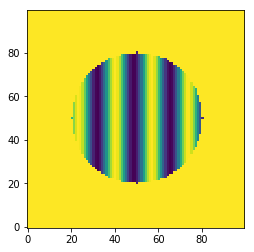

In [136]:
test = np.add(pc_image_K,white_mask)
plt.imshow(test, origin="lower")
#plt.colorbar()
plt.show()

In [137]:
# write FITS

hdu = fits.PrimaryHDU(test)
hdul = fits.HDUList([hdu])
hdul.writeto('junk.fits', overwrite=True)

In [138]:
class fft_img:
    # take FFT of a 2D image

    def __init__(self, image):
        self.image = image

    def fft(self, padding=int(0), pad_mode='constant', mask_thresh=1e-10, mask=True):

        padI = np.pad(self.image, padding, pad_mode)
        # arguments: image, pad size, pad mode, threshold for masking, mask flag
        padI = np.fft.fftshift(padI)
        PhaseExtract = np.fft.fft2(padI)
        PhaseExtract = np.fft.fftshift(PhaseExtract)
        AmpPE = np.absolute(PhaseExtract)
        #ArgPE = np.multiply(np.angle(PhaseExtract),180./np.pi) # degrees
        ArgPE = np.angle(PhaseExtract) # radians

        print("Size of array being FFTed:")
        print(np.shape(PhaseExtract))

        if mask:
            # mask out low-power regions
            AmpPE_masked = ma.masked_where(AmpPE < mask_thresh, AmpPE, copy=False)
            ArgPE_masked = ma.masked_where(AmpPE < mask_thresh, ArgPE, copy=False)
            return AmpPE_masked, ArgPE_masked

        else:
            return AmpPE, ArgPE

In [139]:
amp, arg = fft_img(pc_image_K).fft(padding = 500)

Size of array being FFTed:
(1100, 1100)


In [140]:
# remove central lobe
N = 33
amp[:,int(0.5*np.shape(amp)[1]-N):-2*N] = amp[:,int(0.5*np.shape(amp)[1]+N):]
arg[:,int(0.5*np.shape(arg)[1]-N):-2*N] = arg[:,int(0.5*np.shape(arg)[1]+N):]

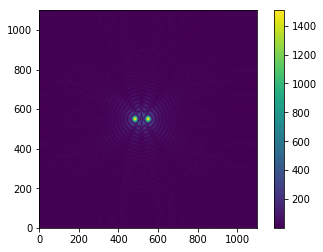

In [141]:
plt.imshow(amp, origin="lower")#, norm=LogNorm(vmin=0.01, vmax=1000))
plt.colorbar()
plt.show()

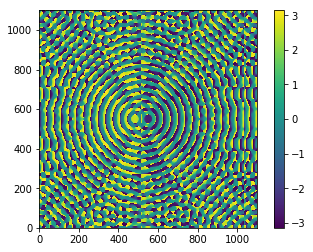

In [142]:
plt.imshow(arg, origin="lower")#, norm=LogNorm(vmin=0.01, vmax=1000))
plt.colorbar()
plt.show()

In [144]:
# write FITS

hdu = fits.PrimaryHDU(amp.data)
hdul = fits.HDUList([hdu])
hdul.writeto('junk.fits', overwrite=True)

In [145]:
pc_image_H = illum_PC(lambda_PC=lambda_H, 
                beta_PC=45, 
                tao12_PC=0, 
                x_coord_pre_rot=xv,
                deg_rot=10)
mask_circle = create_circular_mask(pc_image_H, radius = 25)
pc_image_H = np.multiply(pc_image_H,mask_circle)

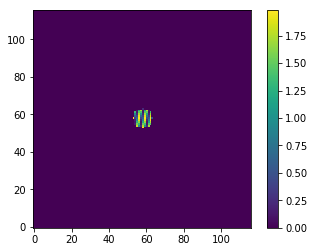

In [14]:
plt.imshow(pc_image_H, origin="lower")
plt.colorbar()
plt.show()

In [16]:
# write FITS

hdu = fits.PrimaryHDU(pc_image_H)
hdul = fits.HDUList([hdu])
hdul.writeto('junk_H.fits', overwrite=True)

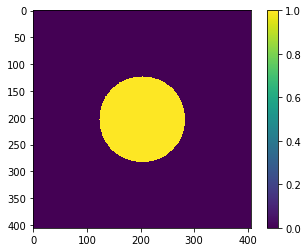

In [20]:
## INTERMISSION: MAKING A MASK FOR PCA DECOMPOSITION OF PSFS IN ALTAIR PROJECT

# initialize a grid
x = np.arange(0, 406)
y = np.arange(0, 406)
xv, yv = np.meshgrid(x, y)

# turn to integers
plt.imshow(mask_circle.astype(int))
plt.colorbar()
plt.show()

# write FITS
hdu = fits.PrimaryHDU(mask_circle.astype(int))
hdul = fits.HDUList([hdu])
hdul.writeto('mask_406x406_rad080.fits', overwrite=True)

In [ ]:
# Figure with 